In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [8]:
df = pd.read_csv("results_tabz.csv")

metric = "LogLoss"
df = df[df["metric"] == metric]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor','LogisticRegressor' , 'RandomForestClassifier', 'LGBMClassifier',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNClassifier': 'TabPFN',
    'GPBoost_LogLoss': 'GP'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

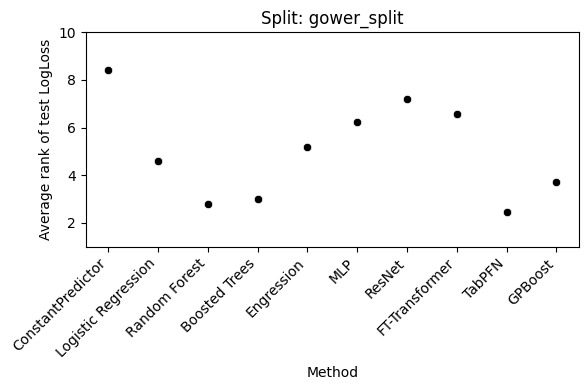

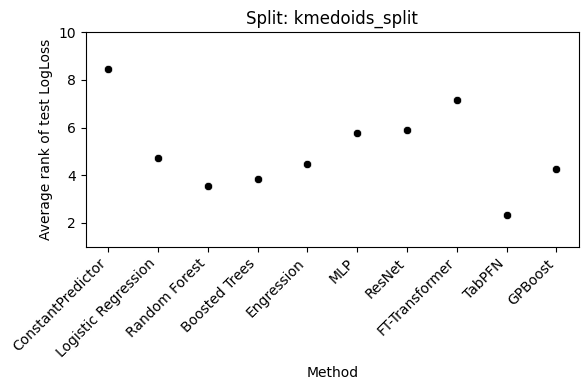

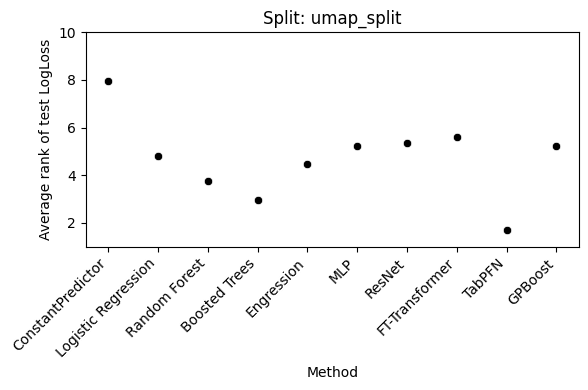

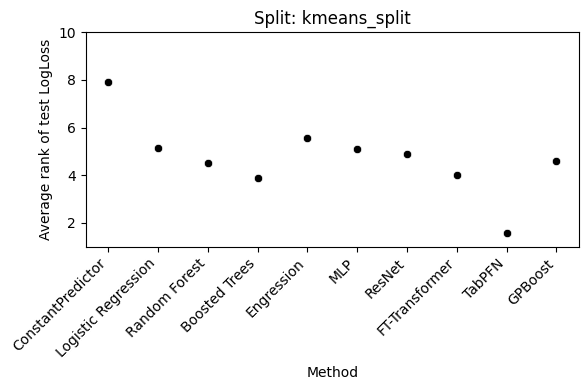

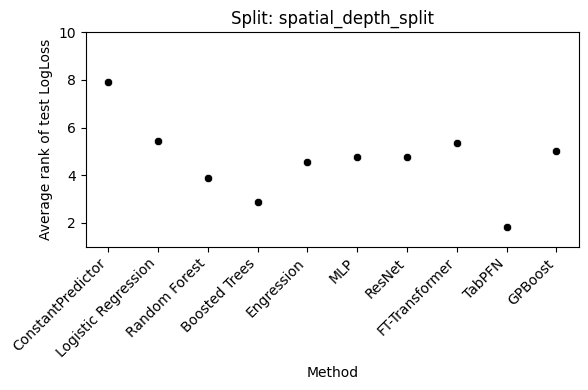

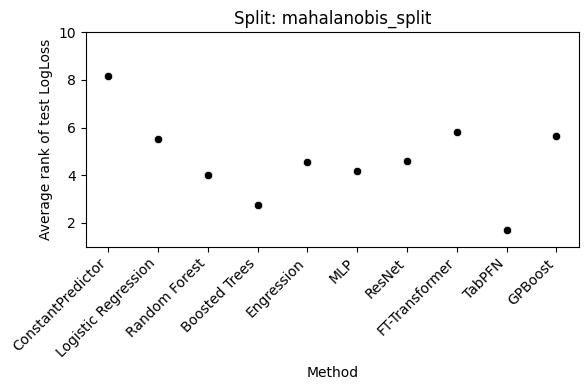

In [4]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    ranks = table.rank(ascending=True)  
    summary = pd.DataFrame({
        "Mean":   ranks.mean(axis=1),
        "Median": ranks.median(axis=1),
        "Std":    ranks.std(axis=1),
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = (
        summary["Method"]
        .astype(str)
        .map(rename_map)
        .fillna(summary["Method"].astype(str))
    )

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Average rank of test LogLoss")
    plt.title(f"Split: {split}")
    plt.ylim(1, 10)        
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # 6) save
    fname = f"{split}_rankings_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()


In [9]:
df = df[df["metric"] == "LogLoss"]

df = df[df["split_method"] != "random_split"]

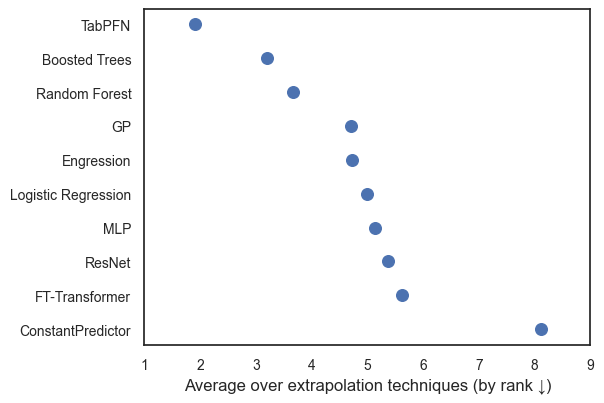

In [12]:
sns.set_theme(style="white", rc={"axes.grid": False})

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
})

df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier',
    'LGBMClassifier',  'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_LogLoss'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

rename_map = {
    'RandomForestClassifier':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':     'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_LogLoss':      'GP'
 
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


overall = overall.dropna(subset=['Mean'])                 # drop NaN rows from reindex
overall = (overall.groupby('Method', as_index=False)      # collapse duplicates (e.g., if two names map to same label)
                 .agg(Mean=('Mean','mean')))

# build order & y from the SAME table
order = overall.sort_values('Mean')['Method']
y = overall.set_index('Method').loc[order, 'Mean']

fig, ax = plt.subplots()
ax.scatter(y.values, np.arange(len(y)), s=70)
ax.set_yticks(np.arange(len(y)))
ax.set_yticklabels(order)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Average over extrapolation techniques (by rank ↓)")
ax.set_ylabel("")
# dynamic x-limit avoids clipping if ranks > 10
ax.set_xlim(1.0, float(np.ceil(y.max() + 0.3)))
plt.tight_layout()

import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/average_rank_LogLoss.pdf", bbox_inches='tight')
plt.show()
plt.close()
